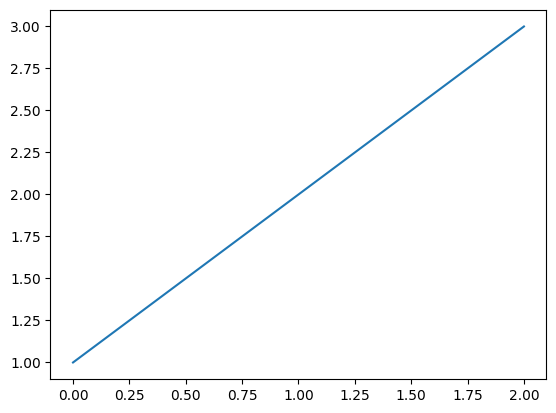

torch.Size([4898, 11])

In [1]:
import os 
import matplotlib.pyplot as plt
plt.plot([1,2,3])
plt.show()
from NNforshow import *

import pandas as pd
import numpy as np
import random
import input_data
import pickle
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


current_file = os.path.abspath ('')
current_dir = os.path.dirname (current_file)
target_file = os.path.join (current_dir+"\\vision\\", "handmadecnn", "archive")
data = pd.read_csv(target_file+"\\winequality-white.csv", sep=";")

data = (data - data.mean())/data.std()
Y = data["quality"].to_numpy()*0.1
X = data.drop("quality", axis=1).to_numpy()
X.shape
MAXNUM = 4898

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)
X.shape

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_with_values(models, dataset_name, num_layers, sample_size, precision=1):
    """
    Plot a line chart with data point values and save the results to a CSV file.

    Parameters:
    models (list): List of model objects containing 'testhis' data.
    dataset_name (str): Name of the dataset (e.g., "Wine Dataset").
    num_layers (int): Number of layers in the model.
    sample_size (int): Size of the training dataset.
    precision (int): Number of decimal places to display for data point values.
    """
    labels = [
        'Our Proposed Method',
        'Our Method with Stabilizer',
        'Baseline Method',
        'L2 Regularization (λ=0.01)',
        'L2 Regularization (λ=0.1)'
    ]
    
    x_values = range(len(models[0].testhis))  # Assuming x-axis is the epoch index
    csv_dict = {'Epoch': x_values}
    
    for i in range(len(models)):
        y = models[i].testhis
        plt.plot(x_values, y, label=labels[i])
        
        # Add data for CSV
        csv_dict[labels[i]] = y
        
        # Display data point values
        for j in range(len(y)):
            plt.text(x_values[j], y[j], f'{y[j]:.{precision}f}', ha='center', va='bottom')
    
    # Set the plot title and labels in English
    plt.title(f'Results on {dataset_name} Dataset with {num_layers} Layers and Sample Size {sample_size}')
    plt.xlabel('Training Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Save the data to a CSV file
    df = pd.DataFrame(csv_dict)
    safe_dataset_name = dataset_name.replace(' ', '_')
    csv_filename = f'{safe_dataset_name}_layers{num_layers}_samples{sample_size}.csv'
    df.to_csv(csv_filename, index=False)



def trainmodelset(modelset):
    all_losses_list = []
    for i in range(5):
        m = modelset.models[i]

        if i <3: #如果属于self.model_my, self.model_mystable, self.model_base
            error = modelset.train_step(m, X, Y)
        else: #如果属于self.model_L2light, self.model_L2heavy
            error = modelset.train_step_L2(m, X, Y)
        m.trainhis.append(error.item())

        mean_result, all_losses = modelset.test_step(m, X,Y)
        m.testhis.append(mean_result.item())
        all_losses_list.append(all_losses)
#         m.teststdhis.append(std_result.item())

        print(i+1, mean_result)
    return all_losses_list

In [3]:
def plot_loss_differences(all_losses_list, baseline_index=2, methods=None):
    """
    绘制不同方法相对于基线方法的 loss 差值图表 (mean ± std)。

    Parameters:
        all_losses_list (list of np.ndarray): 每个元素是一个包含 loss 值的数组。
        baseline_index (int): 基线方法在 all_losses_list 中的索引。
        methods (list of str): 方法的名称列表。如果为 None，将使用 "Method 1", "Method 2" 等。
    """
    if methods is None:
        methods = [f"Method {i+1}" for i in range(len(all_losses_list))]
    
    # 计算 mean 和 std
    baseline_losses = all_losses_list[baseline_index]
    means = []
    stds = []
    for losses in all_losses_list:
        diff = losses - 0
        means.append(diff.mean())
        stds.append(diff.std())
    
    # 创建图形
    plt.figure(figsize=(10, 6))
    x_positions = np.arange(len(methods))
    
    # 绘制 mean 的条形图
    plt.bar(x_positions, means, yerr=stds, capsize=5, alpha=0.7, color='skyblue', label='Mean ± STD')
    
    # 添加横轴标签和标题
    plt.xticks(x_positions, methods, rotation=45, ha="right")
    plt.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.8)  # 添加基线
    plt.ylabel('Loss Difference')
    plt.title('Loss Difference Compared to Baseline with Mean and STD')
    
    # 添加图例
    plt.legend()
    
    # 展示图形
    plt.tight_layout()
    plt.show()


def plot_loss_differences_violin_with_quantiles(all_losses_list, baseline_index=2, methods=None, ylim=(-0.1, 0.1), points=200, quantiles=[0.25, 0.5, 0.75]):
    """
    绘制不同方法相对于基线方法的 loss 差值的平滑 violin plot，并限制纵轴范围，添加四分位数线。

    Parameters:
        all_losses_list (list of np.ndarray): 每个元素是一个包含 loss 值的数组。
        baseline_index (int): 基线方法在 all_losses_list 中的索引。
        methods (list of str): 方法的名称列表。如果为 None，将使用 "Method 1", "Method 2" 等。
        ylim (tuple): 纵轴范围 (min, max)。
        points (int): 用于估计高斯核密度的点数，以平滑小提琴图。
        quantiles (list of float): 需要显示的分位数列表（例如 [0.25, 0.5, 0.75] 表示四分位数）。
    """
    if methods is None:
        methods = [f"Method {i+1}" for i in range(len(all_losses_list))]
    
    # 计算相对于基线的差值
    baseline_losses = all_losses_list[baseline_index]
    differences = [losses - baseline_losses for losses in all_losses_list]
    
    # 创建图形
    plt.figure(figsize=(10, 6))
    
    # 绘制 violin plot
    x_positions = np.arange(len(methods))
    vp = plt.violinplot(differences, positions=x_positions, showmeans=True, showextrema=True, widths=0.7, points=points)
    
    # 添加四分位数线
    for i, data in enumerate(differences):
        quants = np.quantile(data, quantiles)
        for q in quants:
            plt.plot([x_positions[i] - 0.3, x_positions[i] + 0.3], [q, q], color='red', linestyle='--', linewidth=1)
    
    # 添加横轴标签和标题
    plt.xticks(x_positions, methods, rotation=45, ha="right")
    plt.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.8)  # 添加基线
    plt.ylabel('Loss Difference')
    plt.title('Loss Difference Compared to Baseline (Violin Plot with Quantiles)')
    
    # 设置纵轴范围
    plt.ylim(ylim)
    
    # 展示图形
    plt.tight_layout()
    plt.show()

# 示例调用，限制纵轴范围并平滑小提琴图，添加四分位数线
# plot_loss_differences_violin_with_quantiles(all_losses_list, ylim=(-0.01, 0.01), points=500)


In [4]:

inputn=11
nnumber1=20
nnumber2=1


model100 = Regression(MAXNUM, inputn, 100, device)
model100.build_model(2, inputn, nnumber1, nnumber2 )

In [5]:
for i in range(6):
    print("turn ", i)
    all_losses_list100 = trainmodelset(model100)

turn  0
1 tensor(126.8773, device='cuda:0')
2 tensor(285.4995, device='cuda:0')
3 tensor(376.3844, device='cuda:0')
4 tensor(295.1878, device='cuda:0')
5 tensor(95.7230, device='cuda:0')
turn  1
1 tensor(100.5054, device='cuda:0')
2 tensor(122.0663, device='cuda:0')
3 tensor(300.1310, device='cuda:0')
4 tensor(199.7609, device='cuda:0')
5 tensor(98.3156, device='cuda:0')
turn  2
1 tensor(97.5740, device='cuda:0')
2 tensor(101.2297, device='cuda:0')
3 tensor(278.2589, device='cuda:0')
4 tensor(158.0630, device='cuda:0')
5 tensor(99.8415, device='cuda:0')
turn  3
1 tensor(97.4259, device='cuda:0')
2 tensor(95.8387, device='cuda:0')
3 tensor(262.4442, device='cuda:0')
4 tensor(134.2046, device='cuda:0')
5 tensor(102.1184, device='cuda:0')
turn  4
1 tensor(98.3792, device='cuda:0')
2 tensor(91.7980, device='cuda:0')
3 tensor(262.2568, device='cuda:0')
4 tensor(122.2968, device='cuda:0')
5 tensor(100.3021, device='cuda:0')
turn  5
1 tensor(102.0016, device='cuda:0')
2 tensor(91.9735, device

In [6]:
#plot_loss_differences(all_losses_list100)


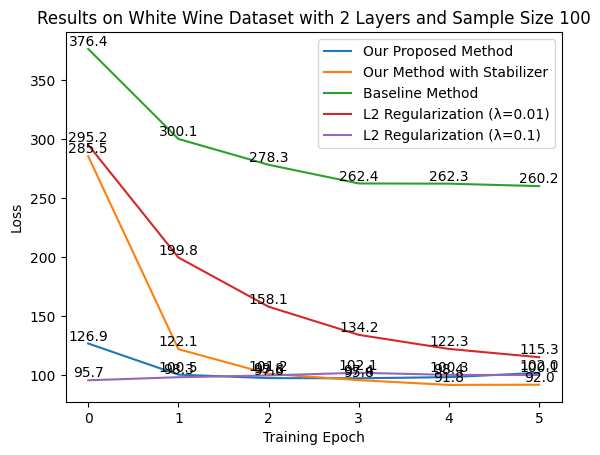

In [7]:
plot_with_values(model100.models, "White Wine", 2, 100)


In [8]:
all_losses_list_noise100 = []
for i in range(5):
    m = model100.models[i]
    mean_result, all_losses =model100.test_step_noise(m, X ,Y)
    all_losses_list_noise100.append(all_losses)
    print( i,  mean_result)

0 tensor(105.6992, device='cuda:0')
1 tensor(95.9928, device='cuda:0')
2 tensor(320.4410, device='cuda:0')
3 tensor(123.5441, device='cuda:0')
4 tensor(100.1339, device='cuda:0')


In [9]:
model500 = Regression(MAXNUM, inputn, 500, device)
model500.build_model(2, inputn, nnumber1, nnumber2 )


In [10]:
for i in range(6):
    print("turn ", i)
    all_losses_list500 =trainmodelset(model500)

turn  0
1 tensor(76.3561, device='cuda:0')
2 tensor(278.6283, device='cuda:0')
3 tensor(102.6643, device='cuda:0')
4 tensor(92.0719, device='cuda:0')
5 tensor(96.4814, device='cuda:0')
turn  1
1 tensor(80.8179, device='cuda:0')
2 tensor(82.8140, device='cuda:0')
3 tensor(80.7729, device='cuda:0')
4 tensor(76.9969, device='cuda:0')
5 tensor(99.0569, device='cuda:0')
turn  2
1 tensor(76.6403, device='cuda:0')
2 tensor(72.9490, device='cuda:0')
3 tensor(82.3015, device='cuda:0')
4 tensor(77.0398, device='cuda:0')
5 tensor(99.4624, device='cuda:0')
turn  3
1 tensor(80.0428, device='cuda:0')
2 tensor(71.1300, device='cuda:0')
3 tensor(81.5732, device='cuda:0')
4 tensor(76.7299, device='cuda:0')
5 tensor(99.9418, device='cuda:0')
turn  4
1 tensor(75.9805, device='cuda:0')
2 tensor(70.7292, device='cuda:0')
3 tensor(76.9844, device='cuda:0')
4 tensor(77.1913, device='cuda:0')
5 tensor(100.2022, device='cuda:0')
turn  5
1 tensor(77.7682, device='cuda:0')
2 tensor(70.8333, device='cuda:0')
3 te

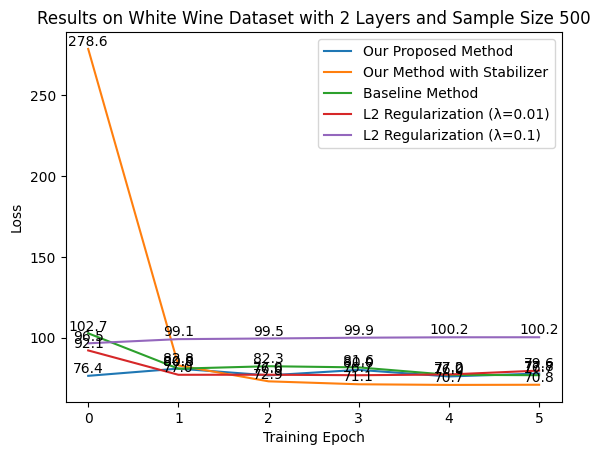

In [15]:

plot_with_values(model500.models, "White Wine", 2, 500)


In [16]:
all_losses_list_noise500 = []
for i in range(5):
    m = model500.models[i]
    mean_result, all_losses =model500.test_step_noise(m, X ,Y)
    all_losses_list_noise500.append(all_losses)
    print( i,  mean_result)


0 tensor(80.4660, device='cuda:0')
1 tensor(72.8629, device='cuda:0')
2 tensor(80.8390, device='cuda:0')
3 tensor(81.3635, device='cuda:0')
4 tensor(100.2269, device='cuda:0')


In [17]:
model1000 = Regression(MAXNUM, inputn, 1000, device)
model1000.build_model(2, inputn, nnumber1, nnumber2 )


In [18]:
for i in range(6):
    print("turn ", i)
    all_losses_list1000 =trainmodelset(model1000)

turn  0
1 tensor(81.8391, device='cuda:0')
2 tensor(282.3985, device='cuda:0')
3 tensor(112.6316, device='cuda:0')
4 tensor(102.2509, device='cuda:0')
5 tensor(92.7224, device='cuda:0')
turn  1
1 tensor(75.8367, device='cuda:0')
2 tensor(87.1373, device='cuda:0')
3 tensor(85.7053, device='cuda:0')
4 tensor(76.6314, device='cuda:0')
5 tensor(98.2403, device='cuda:0')
turn  2
1 tensor(73.5230, device='cuda:0')
2 tensor(72.9913, device='cuda:0')
3 tensor(78.5281, device='cuda:0')
4 tensor(75.0633, device='cuda:0')
5 tensor(99.1423, device='cuda:0')
turn  3
1 tensor(73.3070, device='cuda:0')
2 tensor(70.0205, device='cuda:0')
3 tensor(76.1373, device='cuda:0')
4 tensor(76.9326, device='cuda:0')
5 tensor(99.0443, device='cuda:0')
turn  4
1 tensor(74.0436, device='cuda:0')
2 tensor(68.5751, device='cuda:0')
3 tensor(75.2927, device='cuda:0')
4 tensor(76.5332, device='cuda:0')
5 tensor(99.3829, device='cuda:0')
turn  5
1 tensor(74.4321, device='cuda:0')
2 tensor(68.4743, device='cuda:0')
3 te

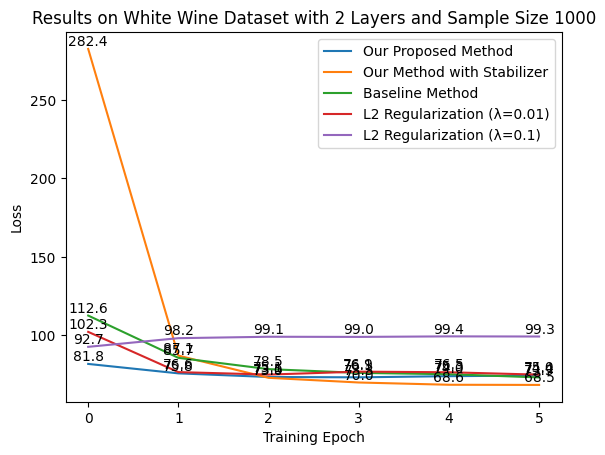

In [19]:
plot_with_values(model1000.models, "White Wine", 2, 1000)


In [20]:
all_losses_list_noise1000 = []
for i in range(5):
    m = model1000.models[i]
    mean_result, all_losses =model1000.test_step_noise(m, X ,Y)
    all_losses_list_noise1000.append(all_losses)
    print( i,  mean_result)


0 tensor(76.8528, device='cuda:0')
1 tensor(70.3321, device='cuda:0')
2 tensor(76.1097, device='cuda:0')
3 tensor(77.7035, device='cuda:0')
4 tensor(99.2988, device='cuda:0')


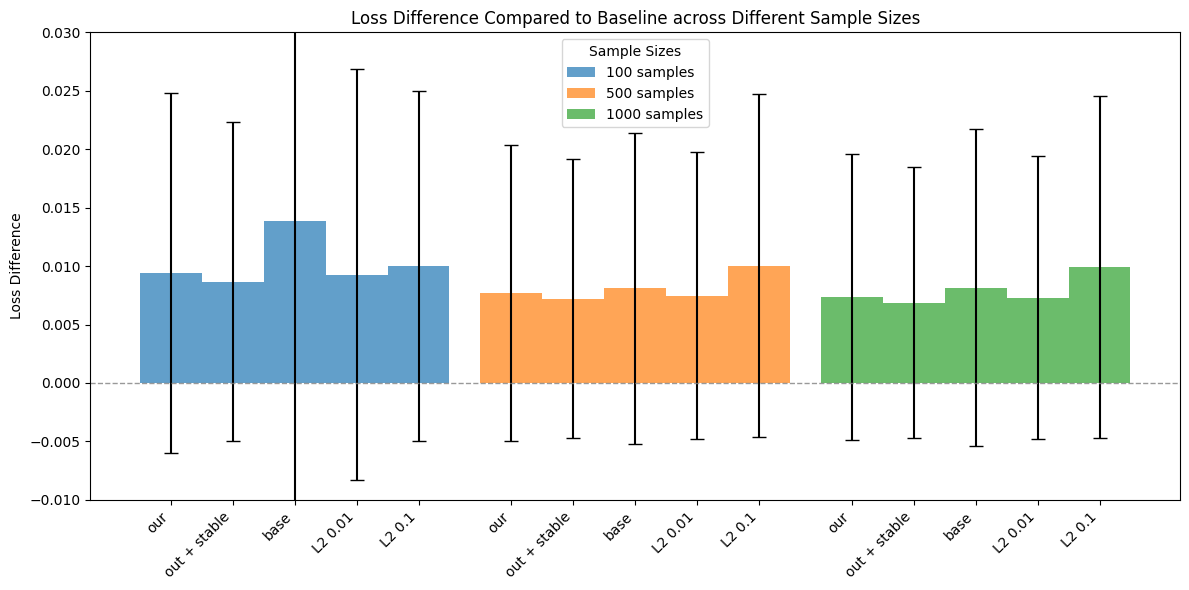

In [37]:
def plot_loss_differences_multiple_groups(loss_groups, group_labels, baseline_index=2, methods=None, ylim=None):
    """
    绘制多个样本组的不同方法相对于基线方法的 loss 差值图表 (mean ± std)，可设置 y 轴范围。
    
    Parameters:
        loss_groups (list of list of np.ndarray): 每个组包含不同方法的 loss 数组列表。
        group_labels (list of str): 每个组的名称列表 (例如 ["100 samples", "500 samples", "1000 samples"]).
        baseline_index (int): 基线方法在每个组的 loss 列表中的索引。
        methods (list of str): 方法的名称列表。如果为 None，将使用 "Method 1", "Method 2" 等。
        ylim (tuple of float): y 轴范围 (ymin, ymax)。如果为 None，不限制 y 轴范围。
    """
    if not group_labels or len(loss_groups) != len(group_labels):
        raise ValueError("group_labels 的长度必须与 loss_groups 的长度一致。")
    
    # 如果没有提供方法名称，自动生成
    if methods is None:
        methods = [f"Method {i+1}" for i in range(len(loss_groups[0]))]
    
    # 确定每组的 x 轴位置范围
    num_methods = len(methods)
    num_groups = len(loss_groups)
    bar_width = 0.2  # 每个柱的宽度
    group_width = num_methods * bar_width + 0.1  # 每组的总宽度，加上一些间隔
    x_group_offsets = np.arange(num_groups) * group_width  # 每组起始位置
    
    # 开始绘图
    plt.figure(figsize=(12, 6))
    
    for group_idx, (loss_list, group_label) in enumerate(zip(loss_groups, group_labels)):
        baseline_losses = loss_list[baseline_index]
        means = []
        stds = []
        
        # 计算 mean 和 std
        for losses in loss_list:
            diff = losses - 0
            means.append(diff.mean())
            stds.append(diff.std())
        
        # 每个方法在当前组的 x 位置
        x_positions = x_group_offsets[group_idx] + np.arange(num_methods) * bar_width
        
        # 绘制柱状图
        plt.bar(x_positions, means, yerr=stds, capsize=5, alpha=0.7, label=group_label, width=bar_width)
    
    # 设置 x 轴标签
    all_x_positions = np.concatenate([x_group_offsets[group_idx] + np.arange(num_methods) * bar_width for group_idx in range(num_groups)])
    all_labels = methods * num_groups
    plt.xticks(all_x_positions, all_labels, rotation=45, ha="right")
    
    # 绘制辅助线、标签和图例
    plt.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.8)  # 添加基线
    plt.ylabel('Loss Difference')
    plt.title('Loss Difference Compared to Baseline across Different Sample Sizes')
    plt.legend(title="Sample Sizes")
    
    # 设置 y 轴范围（如果提供）
    if ylim:
        plt.ylim(ylim)
    
    plt.tight_layout()
    plt.show()

    
plot_loss_differences_multiple_groups(
    loss_groups=[all_losses_list100, all_losses_list500, all_losses_list51000],
    group_labels=["100 samples", "500 samples", "1000 samples"],
    baseline_index=2,  # 基线方法索引
    methods=["our", "out + stable", "base", "L2 0.01", "L2 0.1"],  # 方法名称
    ylim=(-0.01, 0.03)  # 限制 y 轴范围
)


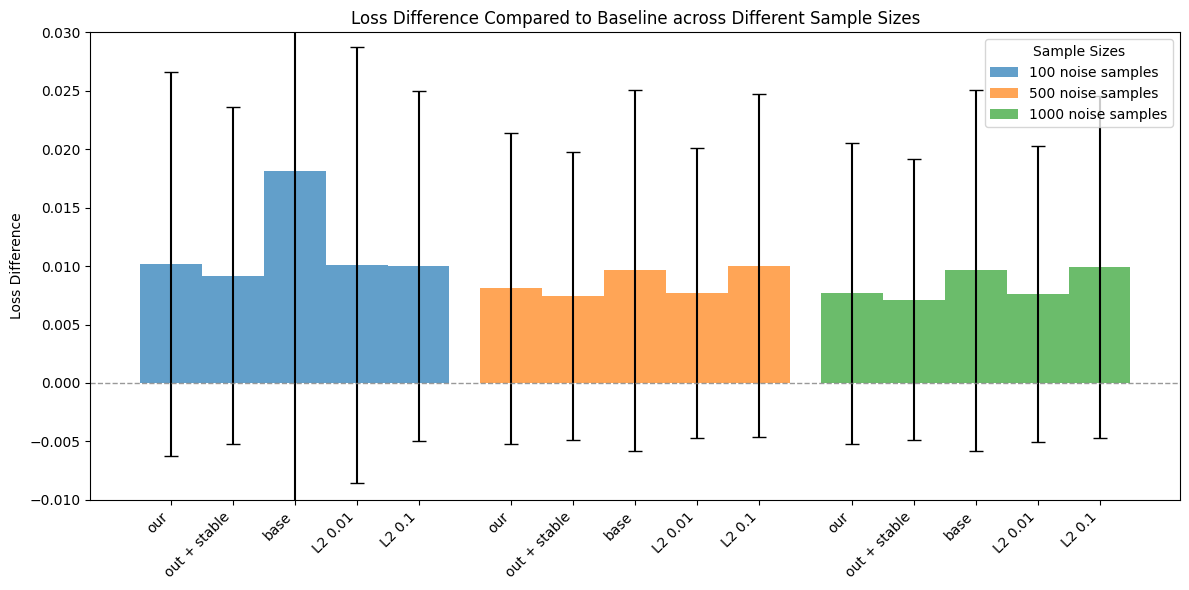

In [35]:

    
plot_loss_differences_multiple_groups(
    loss_groups=[all_losses_list_noise100, all_losses_list_noise500, all_losses_list_noise1000],
    group_labels=["100 noise samples", "500 noise samples", "1000 noise samples"],
    baseline_index=2,  # 基线方法索引
    methods=["our", "out + stable", "base", "L2 0.01", "L2 0.1"],  # 方法名称
    ylim=(-0.01, 0.03)  # 限制 y 轴范围
)


In [21]:

inputn=11
nnumber1=64
nnumber2=32
nnumber3=1

model100 = Regression(MAXNUM, inputn, 100, device)
model100.build_model(3, inputn, nnumber1, nnumber2, nnumber3 )


In [22]:
for i in range(6):
    print("turn ", i)
    all_losses_list1003 =trainmodelset(model100)

turn  0
1 tensor(205.4350, device='cuda:0')
2 tensor(391.8128, device='cuda:0')
3 tensor(654.3820, device='cuda:0')
4 tensor(572.2636, device='cuda:0')
5 tensor(93.6524, device='cuda:0')
turn  1
1 tensor(142.6830, device='cuda:0')
2 tensor(178.8044, device='cuda:0')
3 tensor(622.0873, device='cuda:0')
4 tensor(451.9729, device='cuda:0')
5 tensor(97.7955, device='cuda:0')
turn  2
1 tensor(125.1636, device='cuda:0')
2 tensor(128.3027, device='cuda:0')
3 tensor(634.2885, device='cuda:0')
4 tensor(370.9617, device='cuda:0')
5 tensor(100.1079, device='cuda:0')
turn  3
1 tensor(121.4384, device='cuda:0')
2 tensor(113.3521, device='cuda:0')
3 tensor(641.3808, device='cuda:0')
4 tensor(313.8844, device='cuda:0')
5 tensor(102.2145, device='cuda:0')
turn  4
1 tensor(117.8656, device='cuda:0')
2 tensor(106.7900, device='cuda:0')
3 tensor(645.9028, device='cuda:0')
4 tensor(267.3620, device='cuda:0')
5 tensor(100.3463, device='cuda:0')
turn  5
1 tensor(117.6541, device='cuda:0')
2 tensor(102.7134,

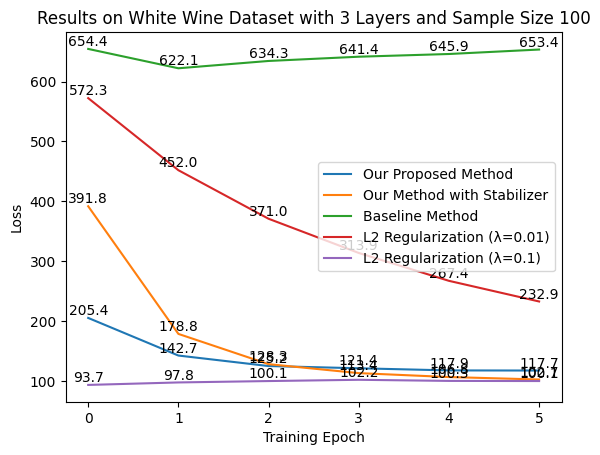

In [23]:
plot_with_values(model100.models, "White Wine", 3, 100)


In [24]:
all_losses_list_noise1003 = []
for i in range(5):
    m = model100.models[i]
    mean_result, all_losses =model100.test_step_noise(m, X ,Y)
    all_losses_list_noise1003.append(all_losses)
    print( i,  mean_result)


0 tensor(126.5617, device='cuda:0')
1 tensor(107.4560, device='cuda:0')
2 tensor(791.5857, device='cuda:0')
3 tensor(264.5969, device='cuda:0')
4 tensor(100.1235, device='cuda:0')


In [25]:
model500 = Regression(MAXNUM, inputn, 500, device)
model500.build_model(3, inputn, nnumber1, nnumber2,nnumber3 )


In [26]:
for i in range(6):
    print("turn ", i)
    all_losses_list5003 =trainmodelset(model500)

turn  0
1 tensor(89.3604, device='cuda:0')
2 tensor(180.9443, device='cuda:0')
3 tensor(203.1104, device='cuda:0')
4 tensor(180.5455, device='cuda:0')
5 tensor(93.7437, device='cuda:0')
turn  1
1 tensor(80.8672, device='cuda:0')
2 tensor(83.6762, device='cuda:0')
3 tensor(147.2167, device='cuda:0')
4 tensor(116.1154, device='cuda:0')
5 tensor(99.0089, device='cuda:0')
turn  2
1 tensor(79.6237, device='cuda:0')
2 tensor(72.3347, device='cuda:0')
3 tensor(127.8259, device='cuda:0')
4 tensor(92.3272, device='cuda:0')
5 tensor(98.0876, device='cuda:0')
turn  3
1 tensor(76.3564, device='cuda:0')
2 tensor(69.7227, device='cuda:0')
3 tensor(119.0838, device='cuda:0')
4 tensor(83.7834, device='cuda:0')
5 tensor(99.8599, device='cuda:0')
turn  4
1 tensor(74.9768, device='cuda:0')
2 tensor(69.6337, device='cuda:0')
3 tensor(110.4415, device='cuda:0')
4 tensor(77.6661, device='cuda:0')
5 tensor(100.1928, device='cuda:0')
turn  5
1 tensor(76.3522, device='cuda:0')
2 tensor(69.8933, device='cuda:0'

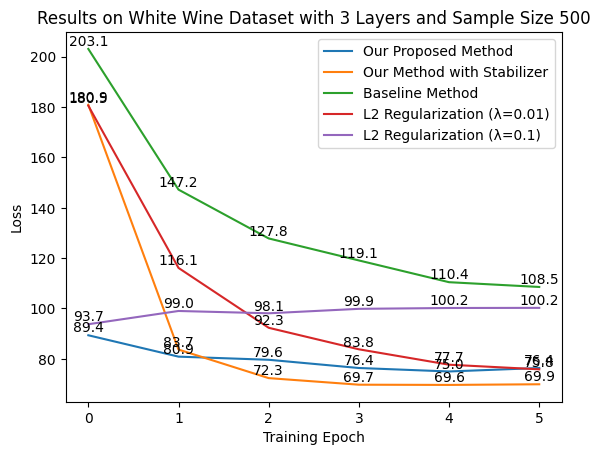

In [27]:
plot_with_values(model500.models, "White Wine", 3, 500)


In [28]:
all_losses_list_noise5003 = []
for i in range(5):
    m = model500.models[i]
    mean_result, all_losses =model500.test_step_noise(m, X ,Y)
    all_losses_list_noise5003.append(all_losses)
    print( i,  mean_result)


0 tensor(79.3033, device='cuda:0')
1 tensor(72.7536, device='cuda:0')
2 tensor(118.0610, device='cuda:0')
3 tensor(79.8249, device='cuda:0')
4 tensor(100.2444, device='cuda:0')


In [29]:
model1000 = Regression(MAXNUM, inputn, 1000, device)
model1000.build_model(3, inputn, nnumber1, nnumber2, nnumber3 )


In [30]:
for i in range(6):
    print("turn ", i)
    all_losses_list10003 =trainmodelset(model1000)

turn  0
1 tensor(84.4897, device='cuda:0')
2 tensor(146.0059, device='cuda:0')
3 tensor(132.8344, device='cuda:0')
4 tensor(128.4665, device='cuda:0')
5 tensor(79.0366, device='cuda:0')
turn  1
1 tensor(77.4428, device='cuda:0')
2 tensor(75.7159, device='cuda:0')
3 tensor(110.8876, device='cuda:0')
4 tensor(92.8007, device='cuda:0')
5 tensor(96.9761, device='cuda:0')
turn  2
1 tensor(75.8862, device='cuda:0')
2 tensor(68.6114, device='cuda:0')
3 tensor(91.4184, device='cuda:0')
4 tensor(82.1720, device='cuda:0')
5 tensor(97.8932, device='cuda:0')
turn  3
1 tensor(72.9599, device='cuda:0')
2 tensor(66.9977, device='cuda:0')
3 tensor(89.9243, device='cuda:0')
4 tensor(78.8904, device='cuda:0')
5 tensor(99.1436, device='cuda:0')
turn  4
1 tensor(76.2612, device='cuda:0')
2 tensor(66.8155, device='cuda:0')
3 tensor(87.7088, device='cuda:0')
4 tensor(79.2178, device='cuda:0')
5 tensor(99.3725, device='cuda:0')
turn  5
1 tensor(76.5990, device='cuda:0')
2 tensor(67.8274, device='cuda:0')
3 t

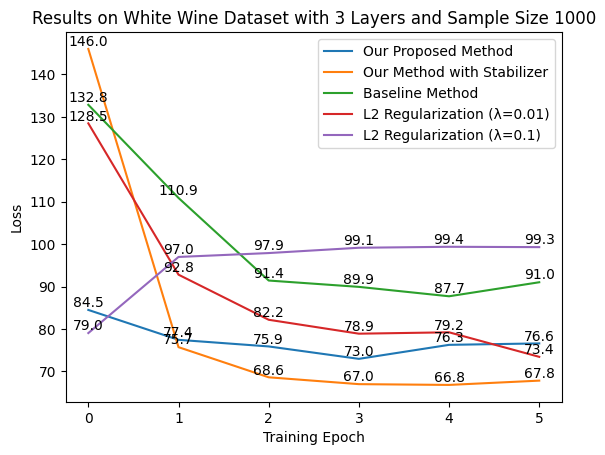

In [31]:
plot_with_values(model1000.models, "White Wine", 3, 1000)


In [32]:
all_losses_list_noise10003 = []
for i in range(5):
    m = model1000.models[i]
    mean_result, all_losses =model1000.test_step_noise(m, X ,Y)
    all_losses_list_noise10003.append(all_losses)
    print( i,  mean_result)


0 tensor(79.4931, device='cuda:0')
1 tensor(70.6041, device='cuda:0')
2 tensor(101.4731, device='cuda:0')
3 tensor(76.0002, device='cuda:0')
4 tensor(99.2908, device='cuda:0')


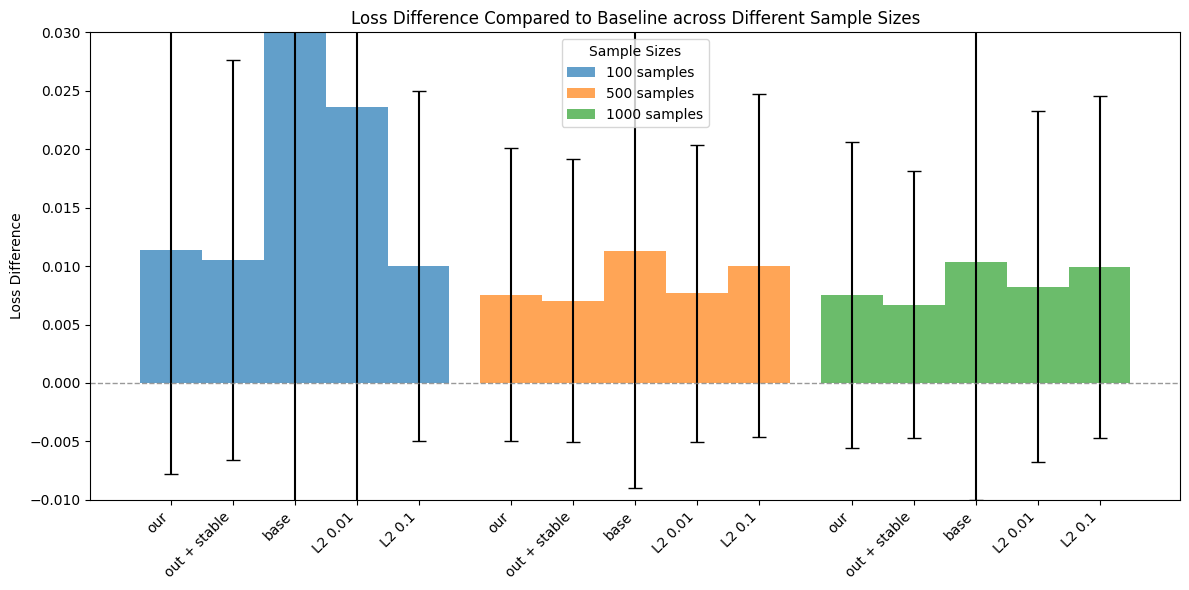

In [50]:
plot_loss_differences_multiple_groups(
    loss_groups=[all_losses_list1003, all_losses_list5003, all_losses_list10003],
    group_labels=["100 samples", "500 samples", "1000 samples"],
    baseline_index=2,  # 基线方法索引
    methods=["our", "out + stable", "base", "L2 0.01", "L2 0.1"],  # 方法名称
    ylim=(-0.01, 0.03)  # 限制 y 轴范围
)

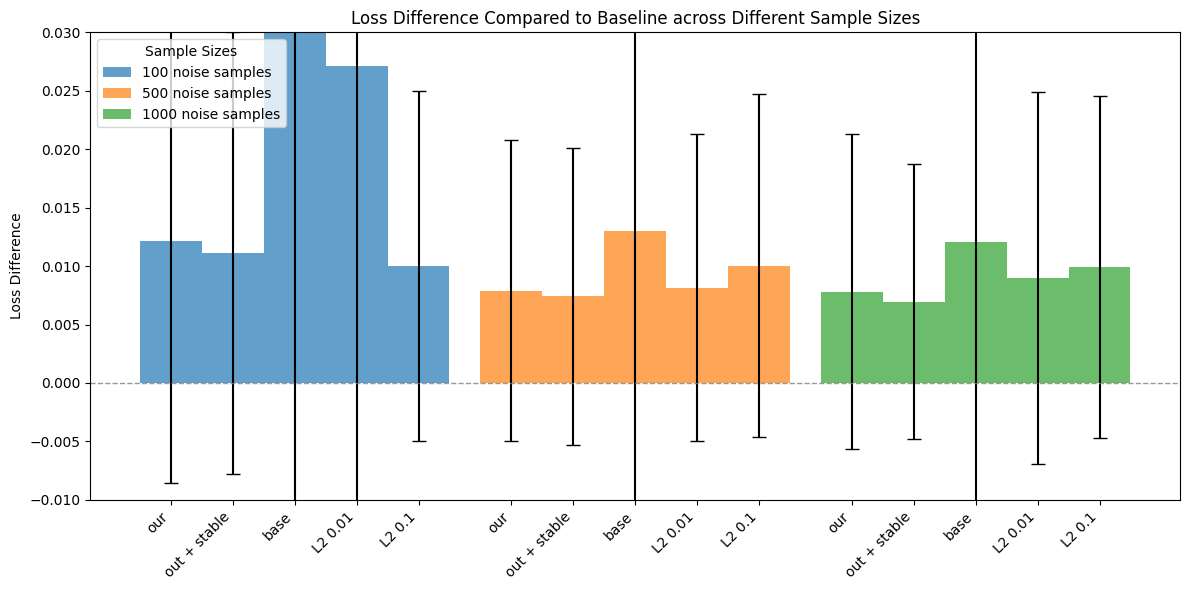

In [51]:

    
plot_loss_differences_multiple_groups(
    loss_groups=[all_losses_list_noise1003, all_losses_list_noise5003, all_losses_list_noise10003],
    group_labels=["100 noise samples", "500 noise samples", "1000 noise samples"],
    baseline_index=2,  # 基线方法索引
    methods=["our", "out + stable", "base", "L2 0.01", "L2 0.1"],  # 方法名称
    ylim=(-0.01, 0.03)  # 限制 y 轴范围
)
